In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from utils.df_loader import load_adult_df, load_compas_df, load_german_df, load_diabetes_df, load_breast_cancer_df
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocess_df
from utils.models import train_three_models, evaluation_test, save_three_models, load_three_models
from utils.cf_proto import  generate_cf_proto_result, process_result
from utils.cf_proto import Recorder
from utils.save import save_result_as_csv

from IPython.display import Image
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from pydotplus import *

### Disable TF2 and enable TF1 for alibi.
tf.get_logger().setLevel(40) 
tf.compat.v1.disable_v2_behavior()
tf.keras.backend.clear_session()
pd.options.mode.chained_assignment = None 
tf.compat.v1.disable_eager_execution()
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False


seed = 123
# tf.random.set_seed(seed)
# np.random.seed(seed)


TF version:  2.0.0
Eager execution enabled:  False


In [2]:
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

In [3]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [4]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [5]:
#### Select dataset ####

dataset_name = 'breast_cancer' # [adult, german, compas]

if dataset_name == 'adult':
    dataset_loading_fn = load_adult_df
elif dataset_name == 'german':
    dataset_loading_fn = load_german_df
elif dataset_name == 'compas':
    dataset_loading_fn = load_compas_df
elif dataset_name == 'diabetes':
    dataset_loading_fn = load_diabetes_df
elif dataset_name == 'breast_cancer':
    dataset_loading_fn = load_breast_cancer_df
else:
    raise Exception("Unsupported dataset")

In [6]:
#pip install pillow
#pip install dtreeviz
#pip install Graphviz
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
proto_dt = pd.read_csv(r'./datasets/eval_proto_breast_cancer_dt_result.csv')

In [7]:
test1 = proto_dt.nsmallest(1,['L2'])
test1

,Unnamed: 0,Unnamed: 0.1,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,scaled_input_concavity_mean,scaled_input_concave points_mean,...,origin_cf_concave points_worst,origin_cf_symmetry_worst,origin_cf_fractal_dimension_worst,origin_cf_diagnosis,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
10,10,0,0.49974,0.324992,0.492779,0.342778,0.334477,0.308018,0.242737,0.372167,...,0.0,0.1565,0.05504,N,8.082521,1.691914,30.0,TRUE,2.382457,0.912942


In [8]:
test = proto_dt.nlargest(1,['L2'])
test

,Unnamed: 0,Unnamed: 0.1,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,scaled_input_concavity_mean,scaled_input_concave points_mean,...,origin_cf_concave points_worst,origin_cf_symmetry_worst,origin_cf_fractal_dimension_worst,origin_cf_diagnosis,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
60,60,0,0.259312,0.484613,0.277659,0.140997,0.595558,0.67548,0.532568,0.424602,...,0.0,0.1565,0.2075,N,10.964023,2.440714,28.0,TRUE,3.334958,1.13101


In [9]:
#### Load datafram info.
df_info = preprocess_df(dataset_loading_fn)
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)
### Input queries for generating counterfactuals
df_info.df.iloc[test_df[:20].index]

### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])

### Load models
models = load_three_models(X_train.shape[-1], dataset_name)

/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
2022-07-09 15:23:54.573248: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) M

In [10]:
#### import evaluation function.
from utils.evaluation import prepare_evaluation_dict
input_and_cf = prepare_evaluation_dict(proto_dt, df_info)


#clf = DecisionTreeClassifier()
class_names = ["No Breast Cancer", "Yes Breast Cancer"]
clf=models['dt']

In [11]:
#filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
PATH = "GitHub/Counterfactual-benchmark/"
dataset_name = 'breast_cancer' # [adult, german, compas]
filepath = "/Users/yu-liangchou/Desktop/cf_experiment/tree.png"
feature_names=df_info.feature_names
graph = export_decision_tree(clf, class_names, dataset_name, filepath) 


#Image(graph.create_png())

[Text(0.5476190476190477, 0.9444444444444444, 'node #0\nradius_worst <= 0.315\ngini = 0.469\nsamples = 455\nvalue = [284, 171]'),
 Text(0.2857142857142857, 0.8333333333333334, 'node #1\nconcave points_worst <= 0.467\ngini = 0.163\nsamples = 302\nvalue = [275, 27]'),
 Text(0.14285714285714285, 0.7222222222222222, 'node #2\narea_se <= 0.158\ngini = 0.03\nsamples = 264\nvalue = [260, 4]'),
 Text(0.09523809523809523, 0.6111111111111112, 'node #3\ntexture_worst <= 0.459\ngini = 0.023\nsamples = 263\nvalue = [260, 3]'),
 Text(0.047619047619047616, 0.5, 'node #4\ngini = 0.0\nsamples = 221\nvalue = [221, 0]'),
 Text(0.14285714285714285, 0.5, 'node #5\nfractal_dimension_se <= 0.014\ngini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.09523809523809523, 0.3888888888888889, 'node #6\ngini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.19047619047619047, 0.3888888888888889, 'node #7\nconcave points_mean <= 0.235\ngini = 0.093\nsamples = 41\nvalue = [39, 2]'),
 Text(0.14285714285714285, 0.2777777

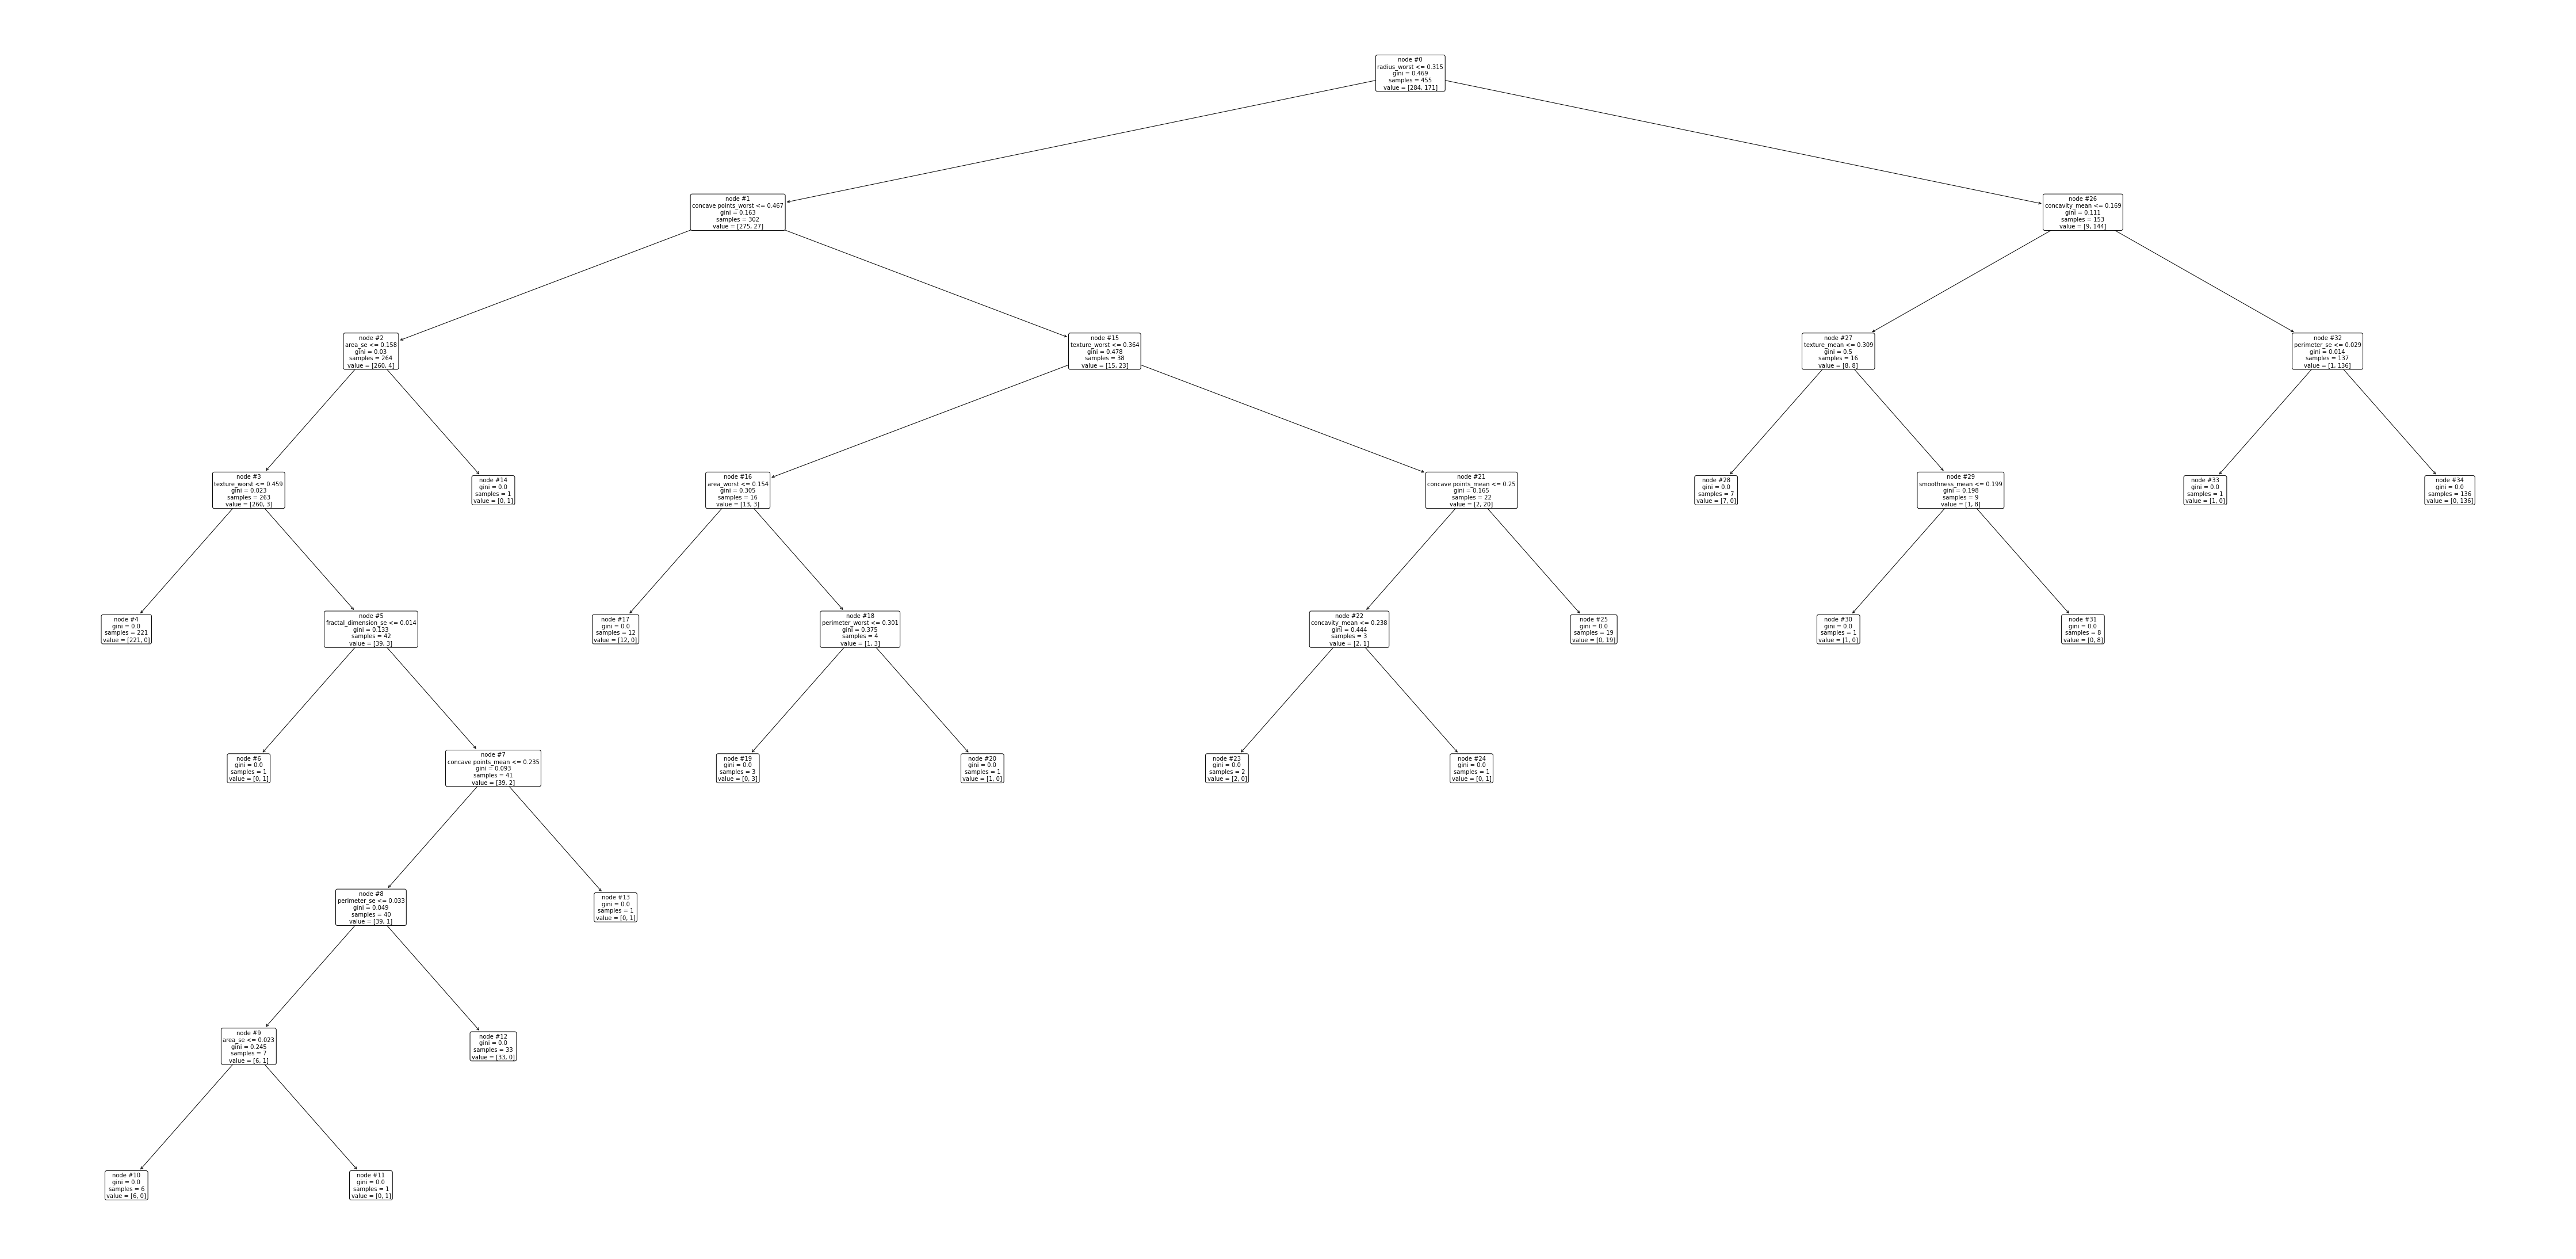

In [12]:
#### Plot the dt tree.
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(80,40))
tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True

In [13]:
#### retrieve the input and cf vectors.
proto_input = input_and_cf['input'].loc[10]
proto_cf = input_and_cf['cf'].loc[10]


In [14]:
#### Present the decision path
tree_path = extract_decision_path(clf, graph, proto_input)
tree_path

[['<radius_worst &le; 0.315',
  'samples = 455',
  'value = [284, 171]',
  'class = No Breast Cancer>'],
 ['<concavity_mean &le; 0.169',
  'samples = 153',
  'value = [9, 144]',
  'class = Yes Breast Cancer>'],
 ['<perimeter_se &le; 0.029',
  'samples = 137',
  'value = [1, 136]',
  'class = Yes Breast Cancer>'],
 ['<gini = 0.0', 'value = [0, 136]', 'class = Yes Breast Cancer>']]

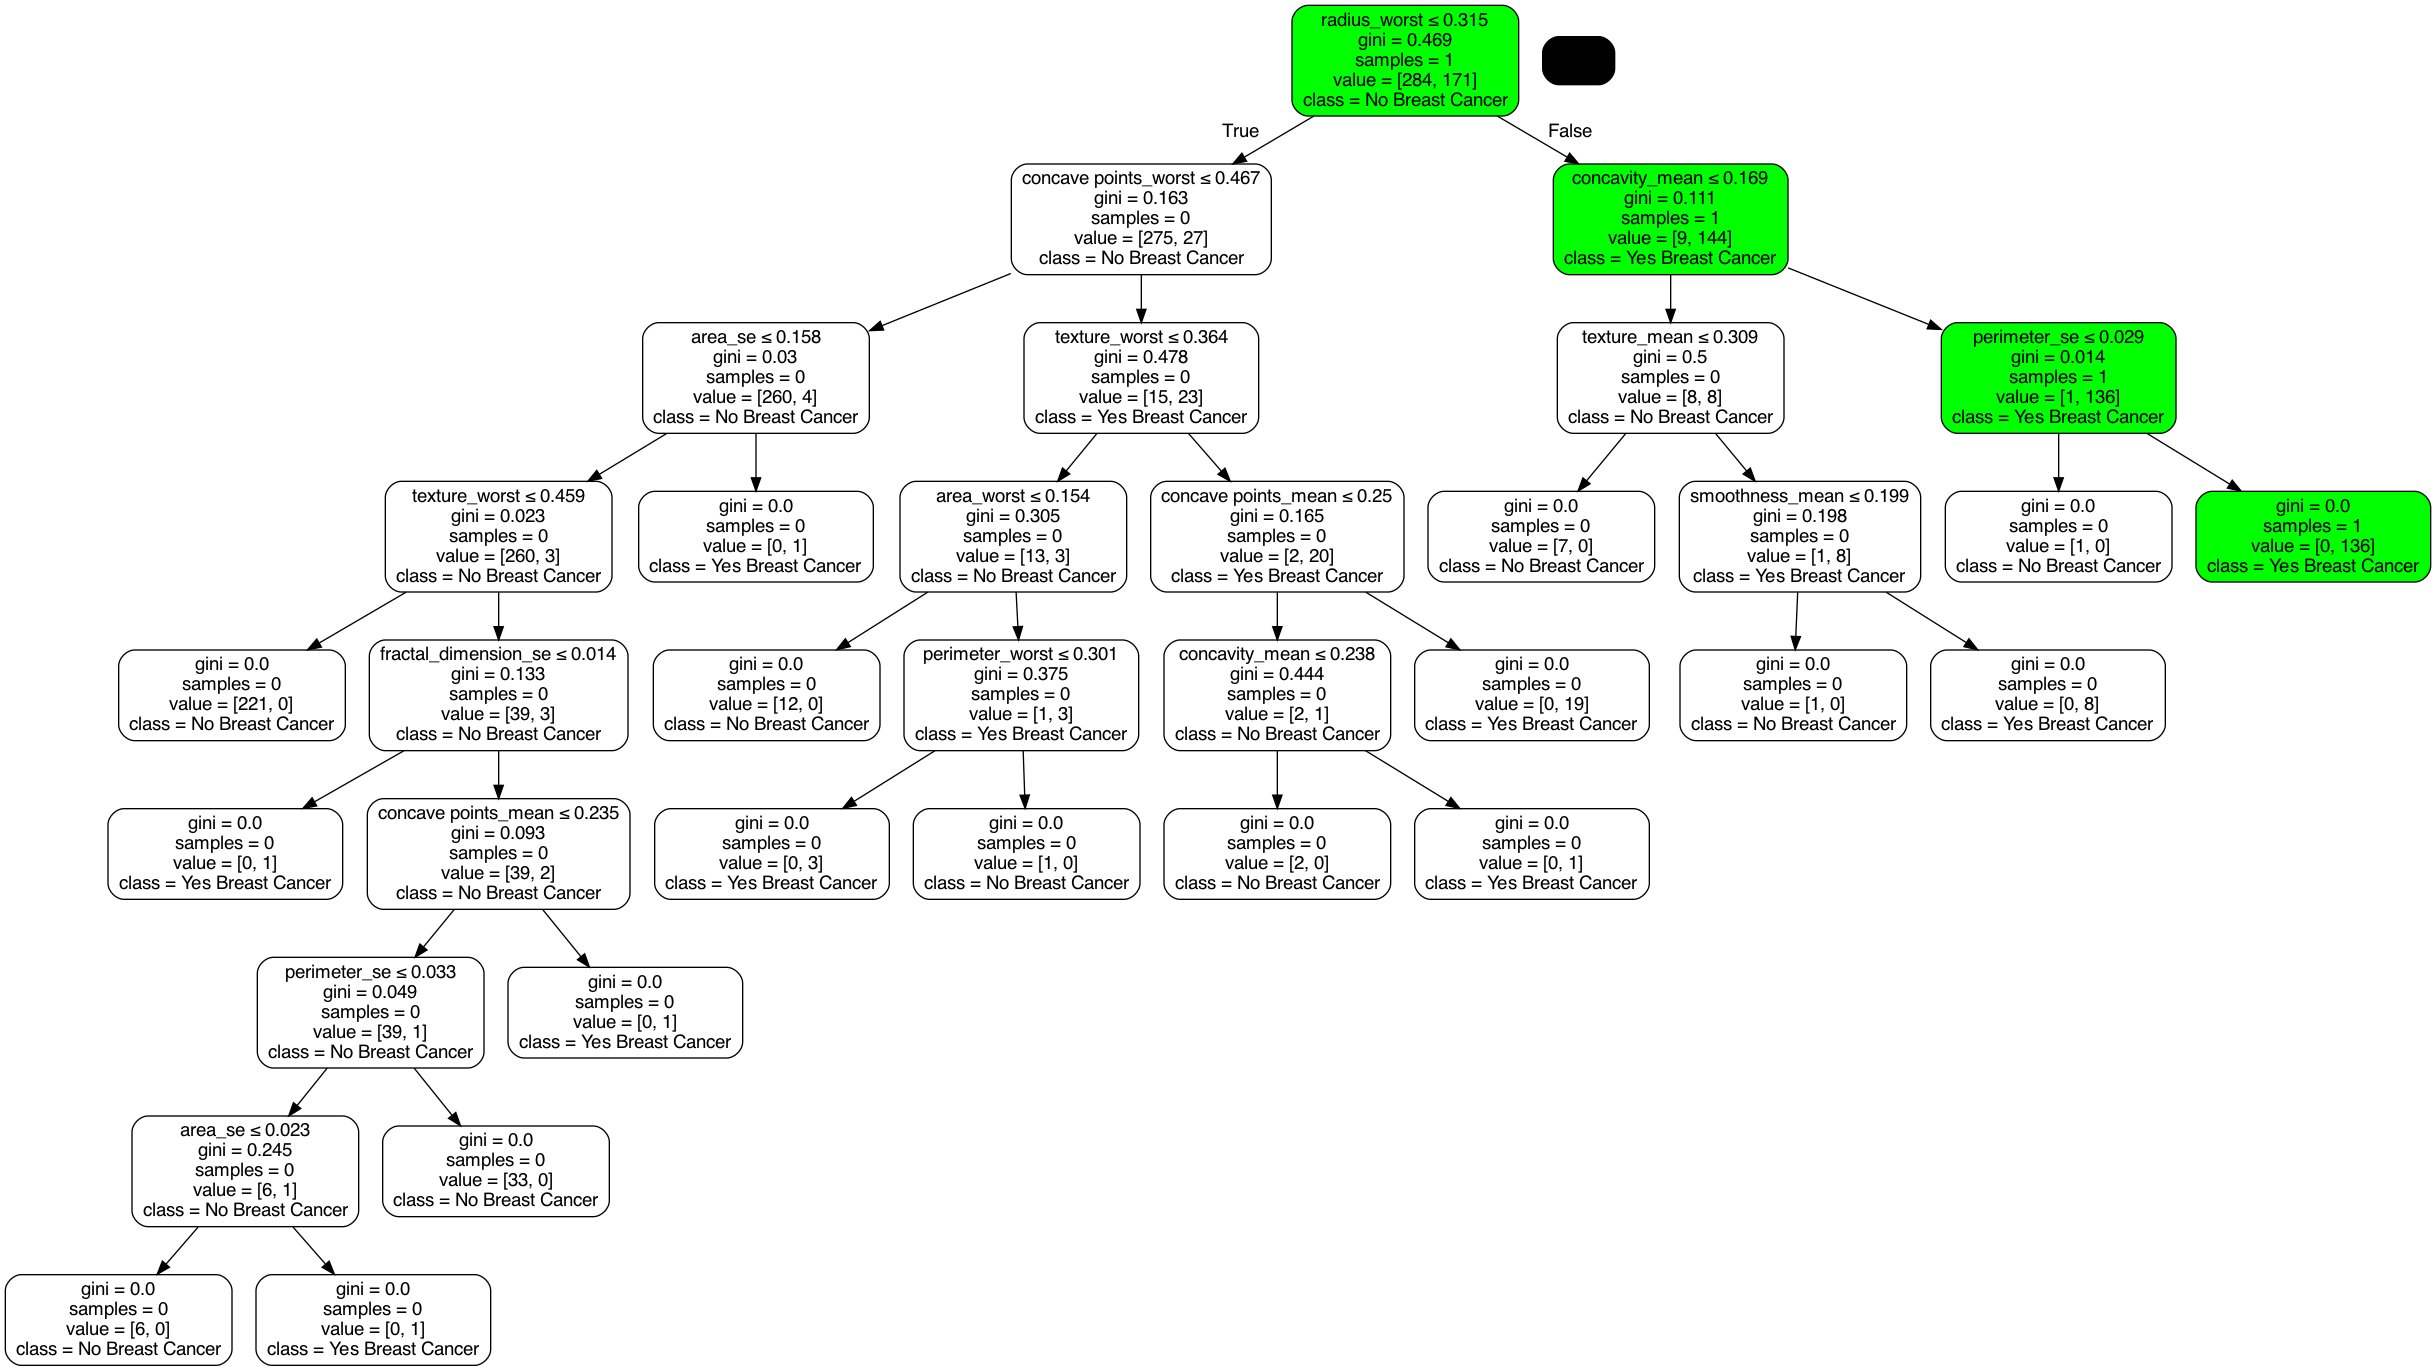

In [15]:
INDX = 10
exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), proto_input, INDX, 'true_positives', filepath)
img


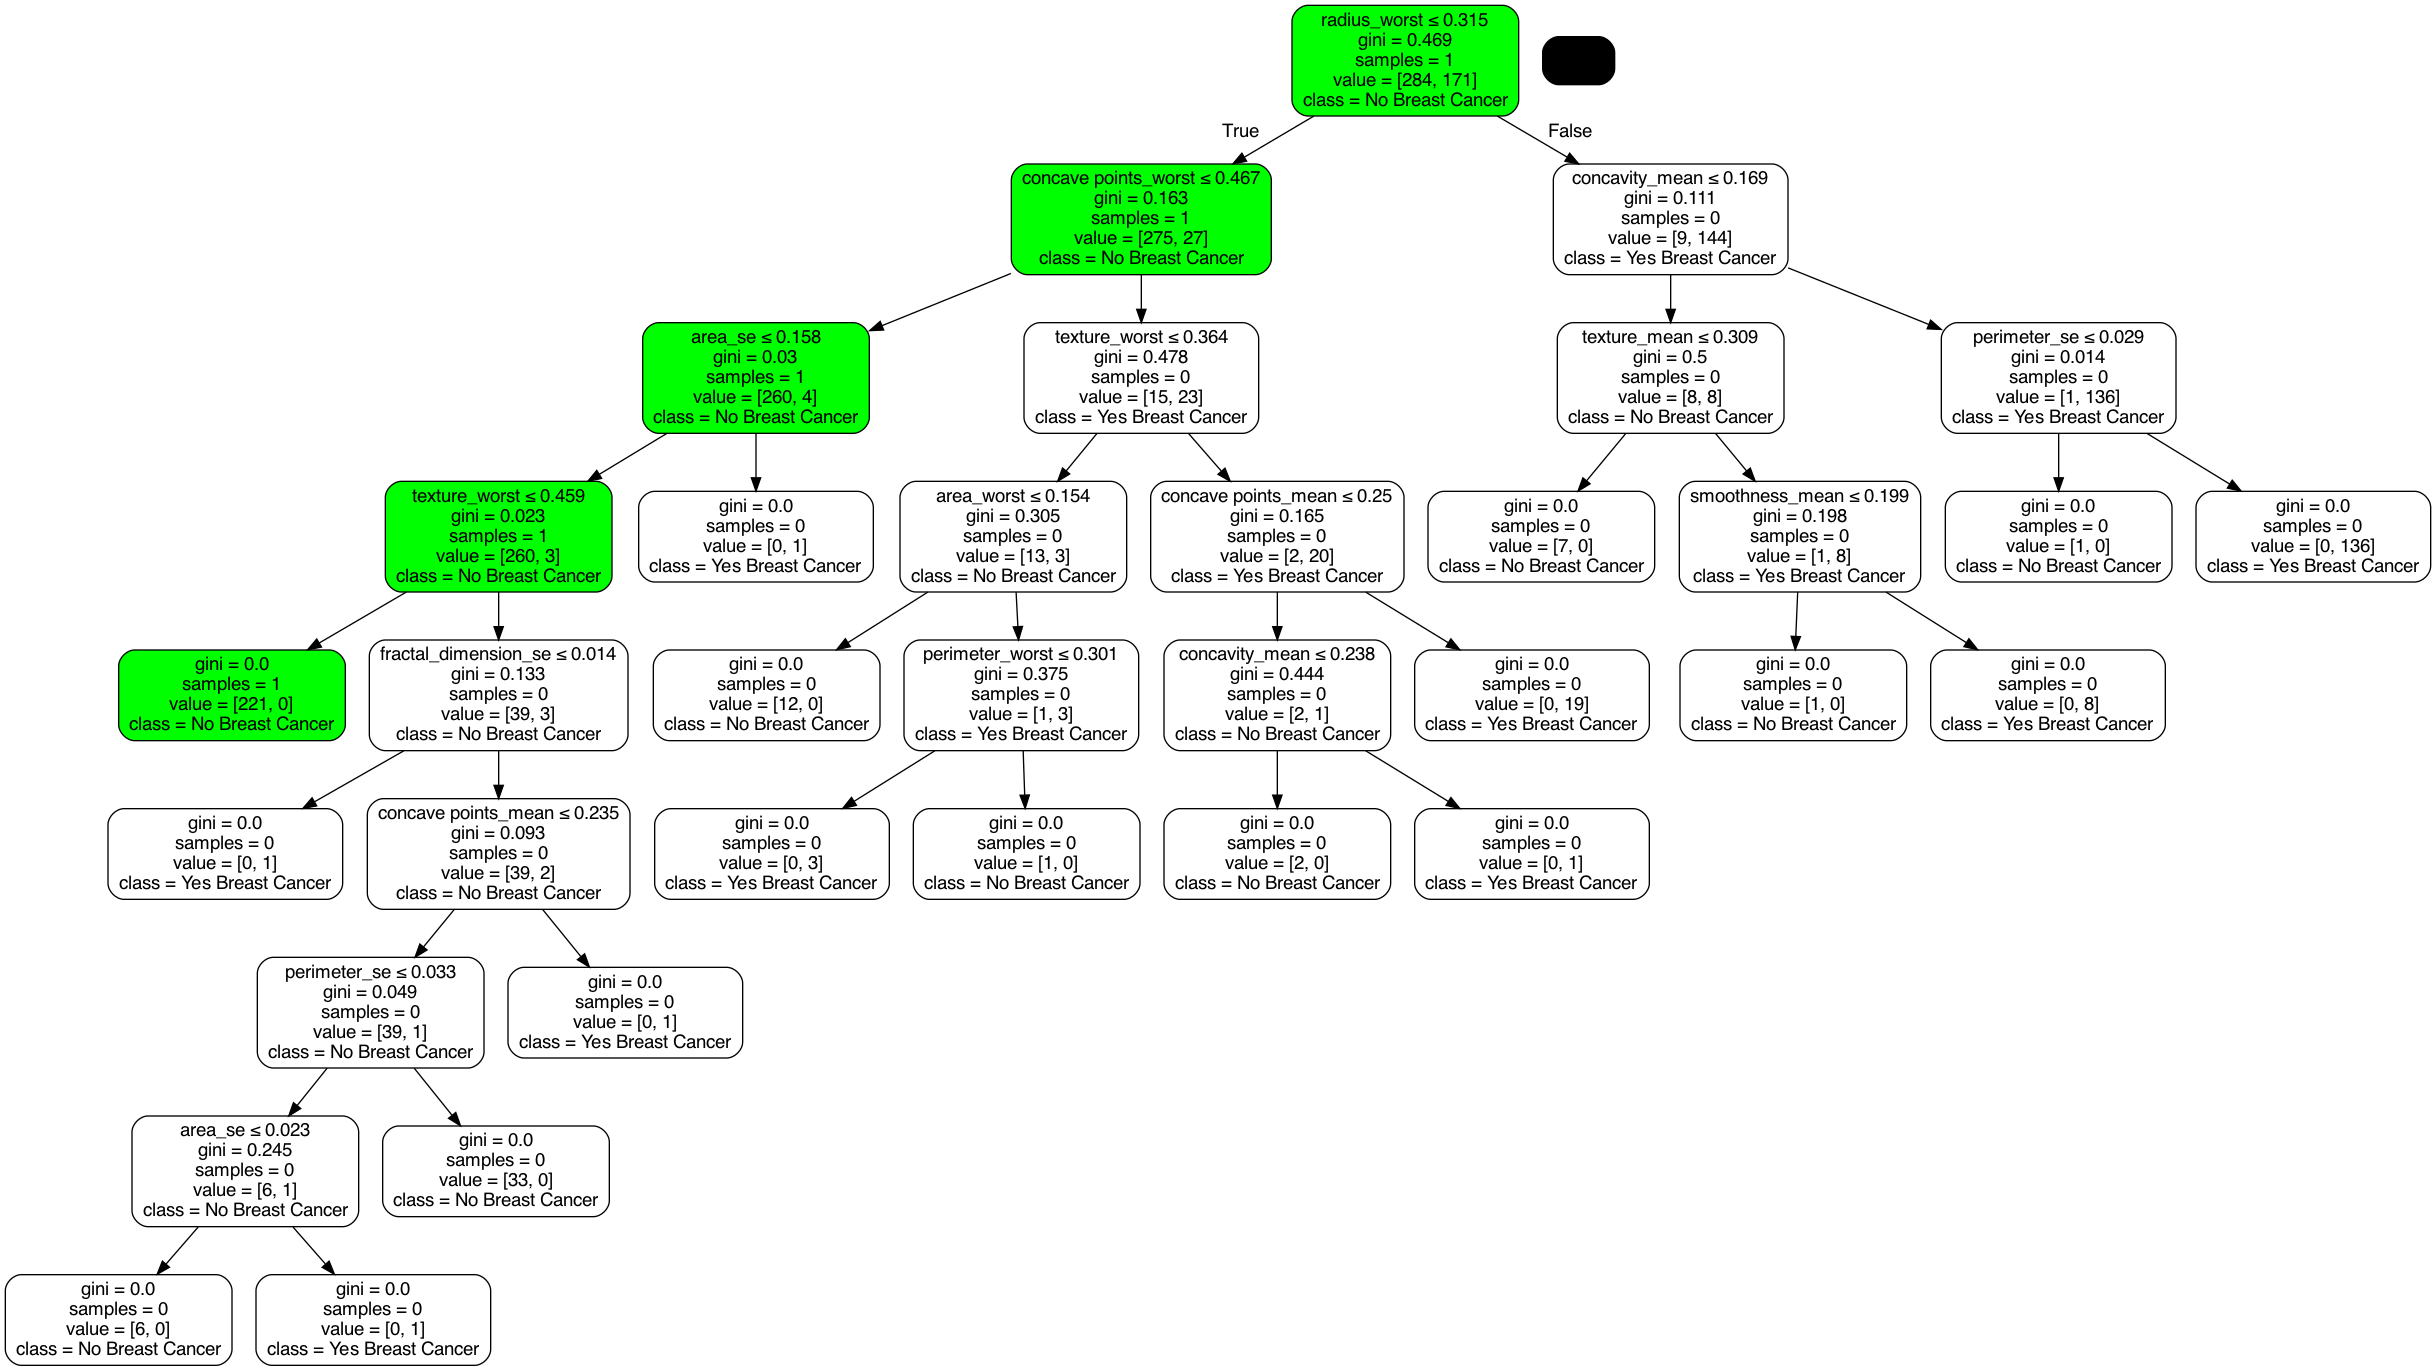

In [16]:
#exp_type = "L2_max"
INDX = 10
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath) , proto_cf, INDX, 'true_positives', filepath)
img

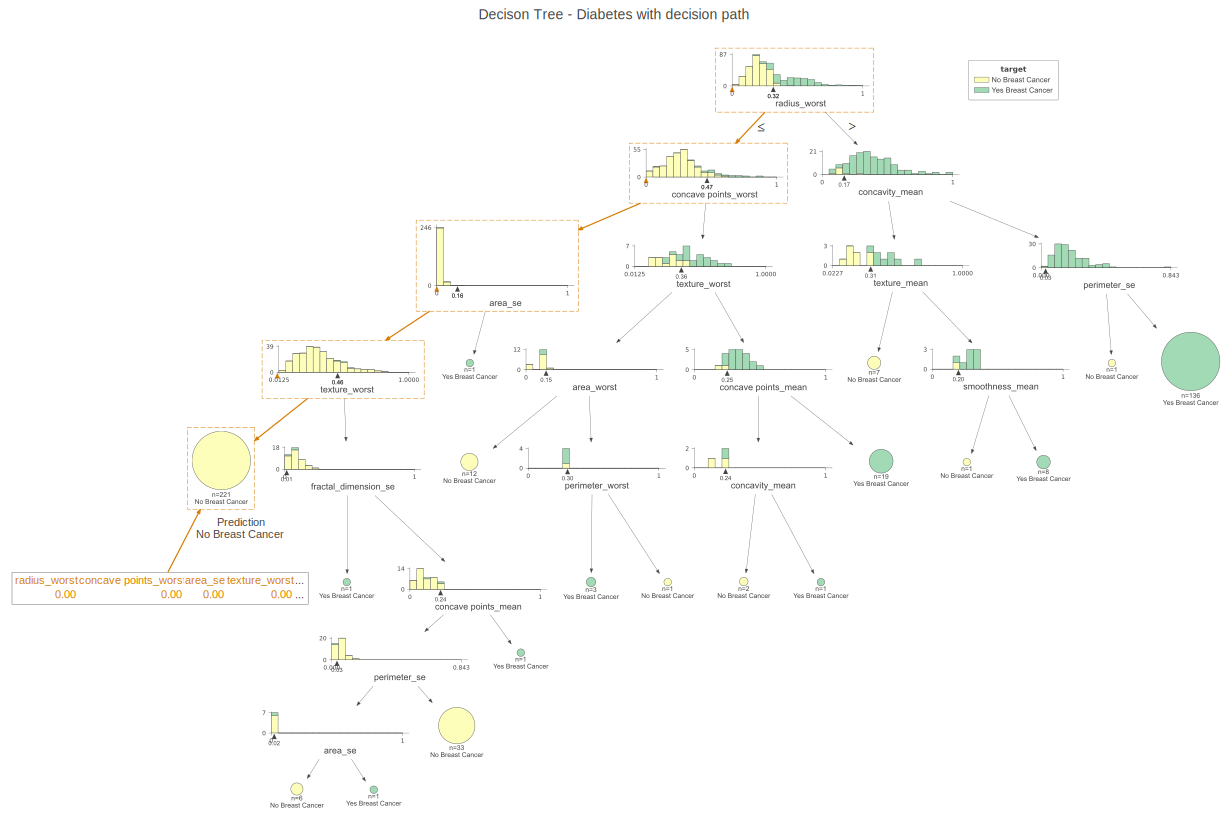

In [17]:
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='target',
               feature_names=df_info.feature_names, 
               class_names=class_names,
               title="Decison Tree - Diabetes with decision path",
               #orientation="LR", 
               X=proto_cf
               )

viz